# League of Legends Model Testing

This notebook allows you to test your trained LoL model directly without the web interface.

In [1]:
import pandas as pd
import pickle
import os

# Load the trained model
with open('lol_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Load model info
with open('model_info.pkl', 'rb') as f:
    model_info = pickle.load(f)

print(f"Model loaded! Accuracy: {model_info['accuracy']:.3f}")
print(f"Features: {model_info['feature_names']}")

Model loaded! Accuracy: 0.701
Features: ['dragon', 'gold_diff', 'gold_per_kill', 'team_kda', 'enemy_kda']


In [2]:
def test_prediction(team_kills, team_deaths, team_assists, team_gold,
                   enemy_kills, enemy_deaths, enemy_assists, enemy_gold,
                   dragon_acquisition='none'):
    """
    Test the model with custom inputs
    dragon_acquisition: 'team', 'enemy', or 'none'
    """
    
    # Calculate features exactly like the model expects
    team_kda = (team_kills + team_assists) / max(1, team_deaths)
    enemy_kda = (enemy_kills + enemy_assists) / max(1, enemy_deaths)
    gold_diff = team_gold - enemy_gold
    total_kills = team_kills + enemy_kills
    gold_per_kill = (team_gold + enemy_gold) / max(1, total_kills)
    
    # Convert dragon to numeric
    dragon = 1 if dragon_acquisition.lower() == 'team' else 0
    
    # Create input dataframe
    input_data = pd.DataFrame({
        'dragon': [dragon],
        'gold_diff': [gold_diff],
        'gold_per_kill': [gold_per_kill],
        'team_kda': [team_kda],
        'enemy_kda': [enemy_kda]
    })
    
    # Get prediction
    win_probability = model.predict_proba(input_data)[0][1]
    prediction = model.predict(input_data)[0]
    
    # Display results
    print("=" * 50)
    print("INPUT STATISTICS:")
    print(f"Your Team:   {team_kills}K/{team_deaths}D/{team_assists}A | {team_gold:,} gold")
    print(f"Enemy Team:  {enemy_kills}K/{enemy_deaths}D/{enemy_assists}A | {enemy_gold:,} gold")
    print(f"Dragons:     {dragon_acquisition.title()}")
    
    print("\nCALCULATED FEATURES:")
    print(f"Team KDA:        {team_kda:.2f}")
    print(f"Enemy KDA:       {enemy_kda:.2f}")
    print(f"Gold Difference: {gold_diff:+,}")
    print(f"Gold per Kill:   {gold_per_kill:.0f}")
    print(f"Dragon Value:    {dragon}")
    
    print("\nPREDICTION:")
    print(f"Win Probability: {win_probability*100:.1f}%")
    print(f"Result:          {'WIN' if prediction == 1 else 'LOSE'}")
    print("=" * 50)
    
    return win_probability, prediction

## Test Scenarios

Run different game scenarios to see how the model responds:

In [3]:
# Test 1: Winning scenario
print("TEST 1: Winning Game")
test_prediction(
    team_kills=15, team_deaths=8, team_assists=22, team_gold=45000,
    enemy_kills=8, enemy_deaths=15, enemy_assists=12, enemy_gold=38000,
    dragon_acquisition='team'
)

TEST 1: Winning Game
INPUT STATISTICS:
Your Team:   15K/8D/22A | 45,000 gold
Enemy Team:  8K/15D/12A | 38,000 gold
Dragons:     Team

CALCULATED FEATURES:
Team KDA:        4.62
Enemy KDA:       1.33
Gold Difference: +7,000
Gold per Kill:   3609
Dragon Value:    1

PREDICTION:
Win Probability: 98.5%
Result:          WIN


(np.float64(0.9847584122845884), np.int64(1))

In [4]:
# Test 2: Losing scenario
print("TEST 2: Losing Game")
test_prediction(
    team_kills=8, team_deaths=15, team_assists=12, team_gold=38000,
    enemy_kills=15, enemy_deaths=8, enemy_assists=22, enemy_gold=45000,
    dragon_acquisition='enemy'
)

TEST 2: Losing Game
INPUT STATISTICS:
Your Team:   8K/15D/12A | 38,000 gold
Enemy Team:  15K/8D/22A | 45,000 gold
Dragons:     Enemy

CALCULATED FEATURES:
Team KDA:        1.33
Enemy KDA:       4.62
Gold Difference: -7,000
Gold per Kill:   3609
Dragon Value:    0

PREDICTION:
Win Probability: 2.8%
Result:          LOSE


(np.float64(0.028328631266633847), np.int64(0))

In [5]:
# Test 3: Balanced game
print("TEST 3: Balanced Game")
test_prediction(
    team_kills=12, team_deaths=12, team_assists=18, team_gold=42000,
    enemy_kills=12, enemy_deaths=12, enemy_assists=18, enemy_gold=42000,
    dragon_acquisition='none'
)

TEST 3: Balanced Game
INPUT STATISTICS:
Your Team:   12K/12D/18A | 42,000 gold
Enemy Team:  12K/12D/18A | 42,000 gold
Dragons:     None

CALCULATED FEATURES:
Team KDA:        2.50
Enemy KDA:       2.50
Gold Difference: +0
Gold per Kill:   3500
Dragon Value:    0

PREDICTION:
Win Probability: 57.4%
Result:          WIN


(np.float64(0.5738690365154541), np.int64(1))

In [6]:
# Test 4: Custom scenario - modify these values!
print("TEST 4: Custom Scenario")
test_prediction(
    team_kills=20,     # Your team kills
    team_deaths=10,    # Your team deaths
    team_assists=25,   # Your team assists
    team_gold=50000,   # Your team gold
    enemy_kills=15,    # Enemy kills
    enemy_deaths=20,   # Enemy deaths
    enemy_assists=20,  # Enemy assists
    enemy_gold=48000,  # Enemy gold
    dragon_acquisition='team'  # 'team', 'enemy', or 'none'
)

TEST 4: Custom Scenario
INPUT STATISTICS:
Your Team:   20K/10D/25A | 50,000 gold
Enemy Team:  15K/20D/20A | 48,000 gold
Dragons:     Team

CALCULATED FEATURES:
Team KDA:        4.50
Enemy KDA:       1.75
Gold Difference: +2,000
Gold per Kill:   2800
Dragon Value:    1

PREDICTION:
Win Probability: 80.8%
Result:          WIN


(np.float64(0.808439041289915), np.int64(1))

## Feature Importance Analysis

See which features have the most impact on predictions:

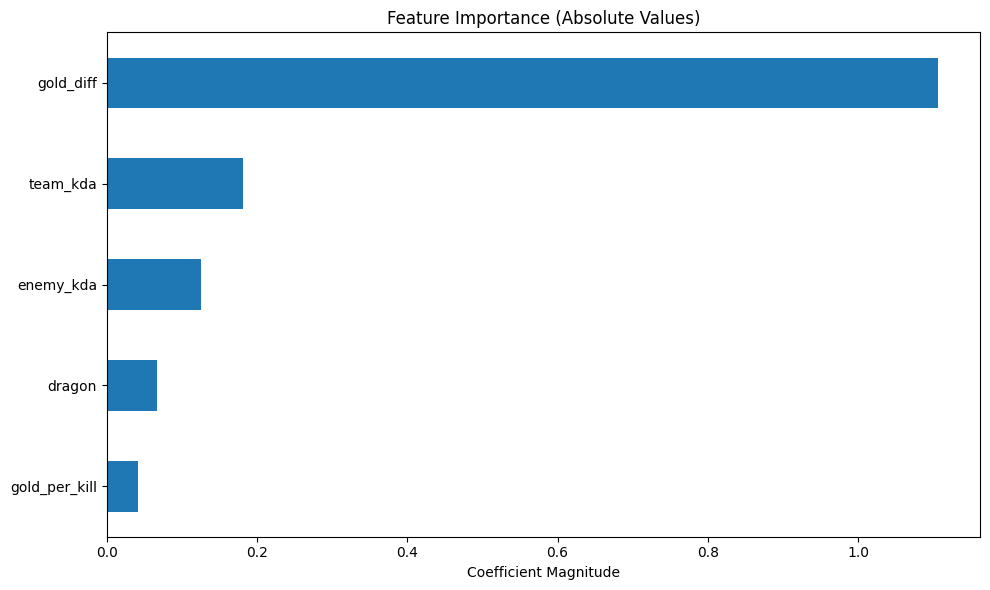

Feature Coefficients:
gold_diff      : +1.107 (helps win)
team_kda       : +0.182 (helps win)
enemy_kda      : +0.125 (helps win)
dragon         : -0.068 (helps lose)
gold_per_kill  : -0.042 (helps lose)


In [8]:
# Display feature importance
import matplotlib.pyplot as plt

feature_importance = pd.Series(model_info['feature_importance'])
feature_importance_sorted = feature_importance.abs().sort_values(ascending=True)

plt.figure(figsize=(10, 6))
feature_importance_sorted.plot(kind='barh')
plt.title('Feature Importance (Absolute Values)')
plt.xlabel('Coefficient Magnitude')
plt.tight_layout()
plt.show()

print("Feature Coefficients:")
for feature, coef in feature_importance.sort_values(key=abs, ascending=False).items():
    direction = "helps win" if coef > 0 else "helps lose"
    print(f"{feature:15s}: {coef:+.3f} ({direction})")

## Comprehensive Model Analysis

Let's create multiple visualizations to understand how the model behaves across different scenarios:

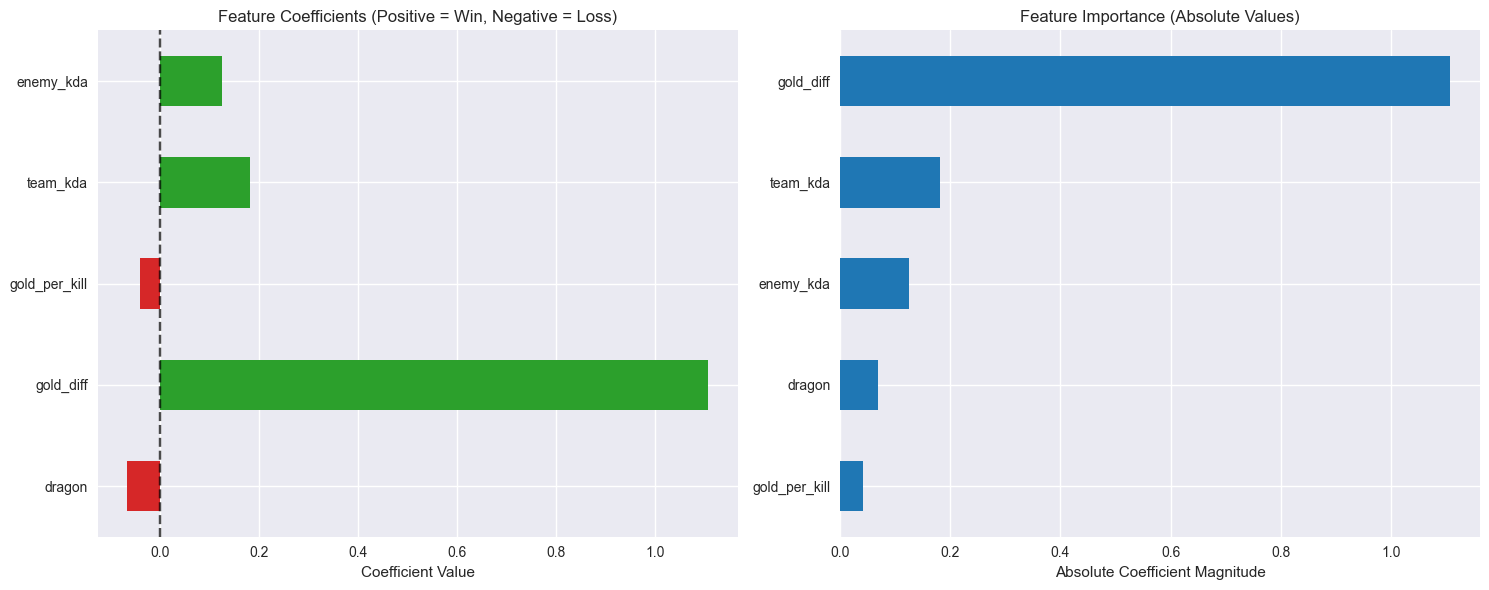

Feature Analysis:
gold_diff      : +1.1070 ([+] Helps Win)
team_kda       : +0.1817 ([+] Helps Win)
enemy_kda      : +0.1255 ([+] Helps Win)
dragon         : -0.0675 ([-] Helps Lose)
gold_per_kill  : -0.0417 ([-] Helps Lose)


In [17]:
# 1. Feature Importance Visualization (Enhanced)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for better looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Horizontal bar chart
feature_importance = pd.Series(model_info['feature_importance'])
colors = ['#d62728' if x < 0 else '#2ca02c' for x in feature_importance.values]  # Using distinct colors
feature_importance.plot(kind='barh', ax=ax1, color=colors)
ax1.set_title('Feature Coefficients (Positive = Win, Negative = Loss)')
ax1.set_xlabel('Coefficient Value')
ax1.axvline(x=0, color='black', linestyle='--', alpha=0.7)

# Absolute importance
feature_importance.abs().sort_values().plot(kind='barh', ax=ax2, color='#1f77b4')
ax2.set_title('Feature Importance (Absolute Values)')
ax2.set_xlabel('Absolute Coefficient Magnitude')

plt.tight_layout()
plt.show()

print("Feature Analysis:")
for feature, coef in feature_importance.sort_values(key=abs, ascending=False).items():
    direction = "[+] Helps Win" if coef > 0 else "[-] Helps Lose"
    print(f"{feature:15s}: {coef:+.4f} ({direction})")

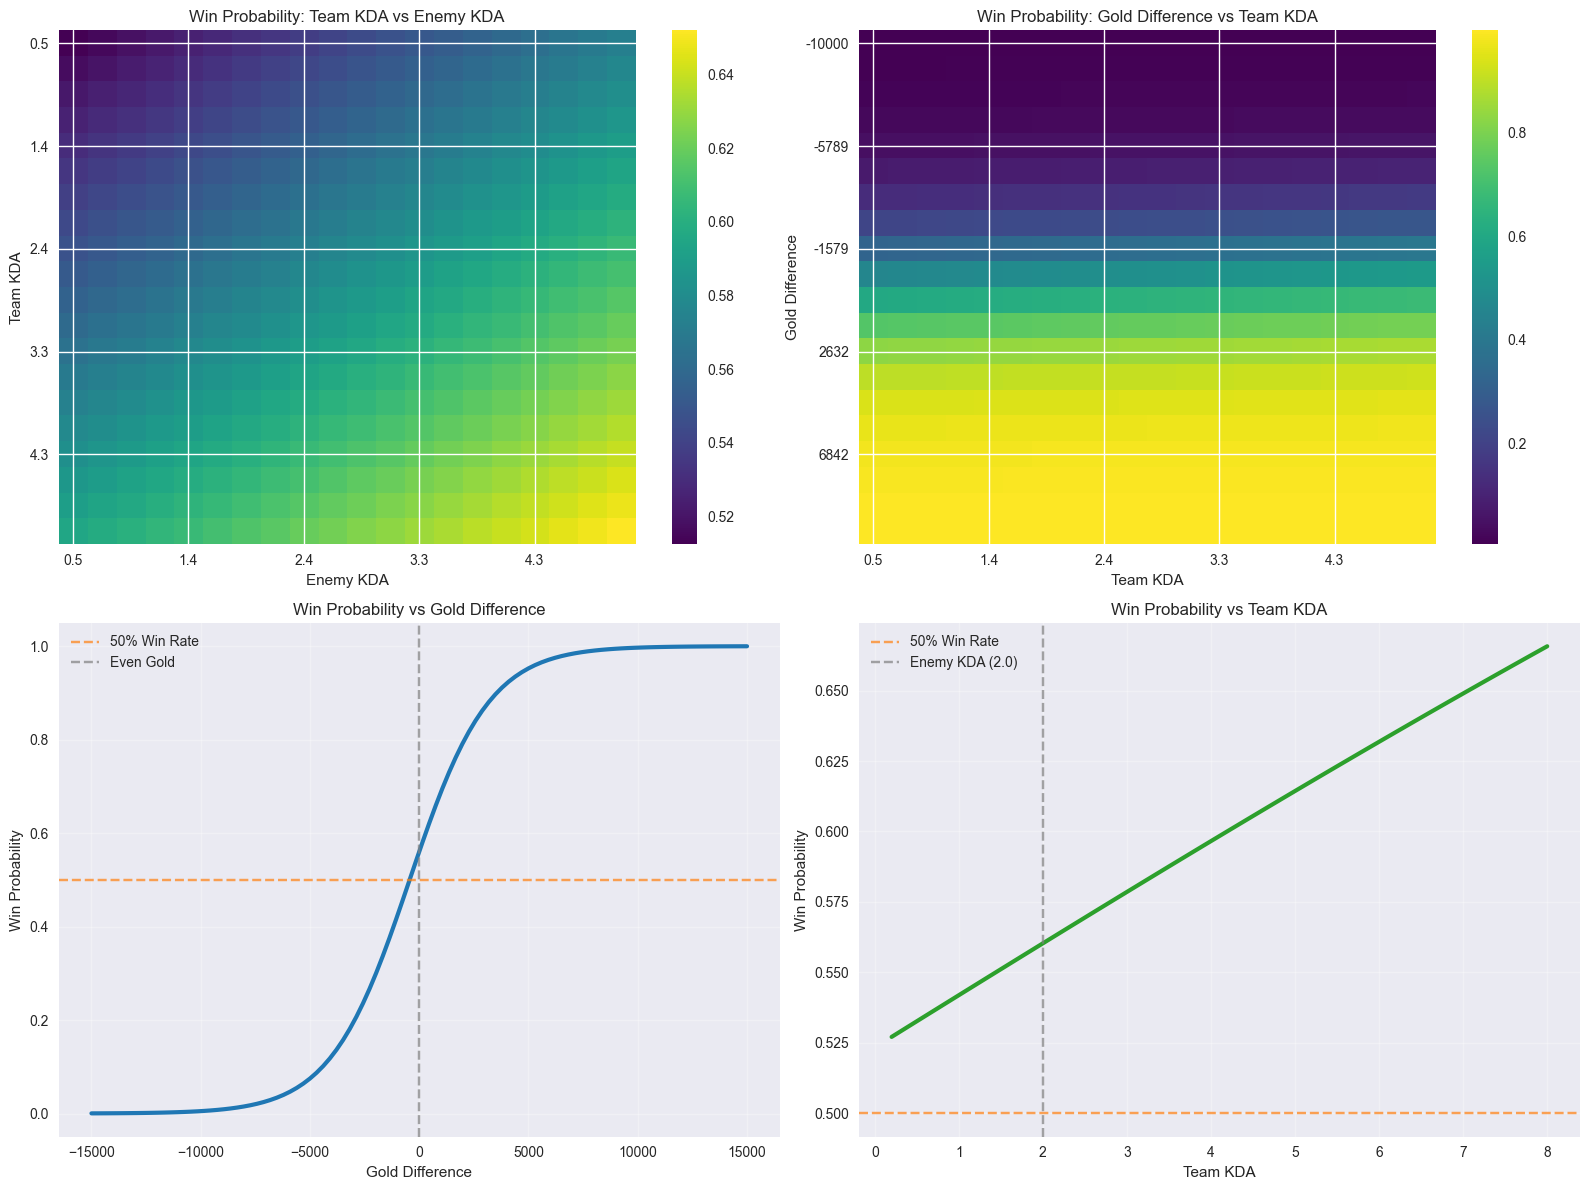

In [18]:
# 2. Win Probability Heatmaps
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Generate test data ranges
team_kdas = np.linspace(0.5, 5.0, 20)
enemy_kdas = np.linspace(0.5, 5.0, 20)
gold_diffs = np.linspace(-10000, 10000, 20)

# Heatmap 1: Team KDA vs Enemy KDA
kda_probs = np.zeros((len(team_kdas), len(enemy_kdas)))
for i, team_kda in enumerate(team_kdas):
    for j, enemy_kda in enumerate(enemy_kdas):
        input_data = pd.DataFrame({
            'dragon': [0],
            'gold_diff': [0],
            'gold_per_kill': [3000],
            'team_kda': [team_kda],
            'enemy_kda': [enemy_kda]
        })
        kda_probs[i, j] = model.predict_proba(input_data)[0][1]

im1 = axes[0,0].imshow(kda_probs, cmap='viridis', aspect='auto')
axes[0,0].set_title('Win Probability: Team KDA vs Enemy KDA')
axes[0,0].set_xlabel('Enemy KDA')
axes[0,0].set_ylabel('Team KDA')
axes[0,0].set_xticks(range(0, 20, 4))
axes[0,0].set_xticklabels([f'{enemy_kdas[i]:.1f}' for i in range(0, 20, 4)])
axes[0,0].set_yticks(range(0, 20, 4))
axes[0,0].set_yticklabels([f'{team_kdas[i]:.1f}' for i in range(0, 20, 4)])
plt.colorbar(im1, ax=axes[0,0])

# Heatmap 2: Gold Difference vs Team KDA
gold_kda_probs = np.zeros((len(gold_diffs), len(team_kdas)))
for i, gold_diff in enumerate(gold_diffs):
    for j, team_kda in enumerate(team_kdas):
        input_data = pd.DataFrame({
            'dragon': [0],
            'gold_diff': [gold_diff],
            'gold_per_kill': [3000],
            'team_kda': [team_kda],
            'enemy_kda': [2.0]
        })
        gold_kda_probs[i, j] = model.predict_proba(input_data)[0][1]

im2 = axes[0,1].imshow(gold_kda_probs, cmap='viridis', aspect='auto')
axes[0,1].set_title('Win Probability: Gold Difference vs Team KDA')
axes[0,1].set_xlabel('Team KDA')
axes[0,1].set_ylabel('Gold Difference')
axes[0,1].set_xticks(range(0, 20, 4))
axes[0,1].set_xticklabels([f'{team_kdas[i]:.1f}' for i in range(0, 20, 4)])
axes[0,1].set_yticks(range(0, 20, 4))
axes[0,1].set_yticklabels([f'{gold_diffs[i]:.0f}' for i in range(0, 20, 4)])
plt.colorbar(im2, ax=axes[0,1])

# Line Plot 3: Win Probability vs Gold Difference
gold_range = np.linspace(-15000, 15000, 100)
gold_probs = []
for gold_diff in gold_range:
    input_data = pd.DataFrame({
        'dragon': [0],
        'gold_diff': [gold_diff],
        'gold_per_kill': [3000],
        'team_kda': [2.0],
        'enemy_kda': [2.0]
    })
    gold_probs.append(model.predict_proba(input_data)[0][1])

axes[1,0].plot(gold_range, gold_probs, linewidth=3, color='#1f77b4')
axes[1,0].set_title('Win Probability vs Gold Difference')
axes[1,0].set_xlabel('Gold Difference')
axes[1,0].set_ylabel('Win Probability')
axes[1,0].axhline(y=0.5, color='#ff7f0e', linestyle='--', alpha=0.7, label='50% Win Rate')
axes[1,0].axvline(x=0, color='gray', linestyle='--', alpha=0.7, label='Even Gold')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].legend()

# Line Plot 4: Win Probability vs KDA Ratio
kda_ratio_range = np.linspace(0.2, 8.0, 100)
kda_ratio_probs = []
for kda_ratio in kda_ratio_range:
    input_data = pd.DataFrame({
        'dragon': [0],
        'gold_diff': [0],
        'gold_per_kill': [3000],
        'team_kda': [kda_ratio],
        'enemy_kda': [2.0]
    })
    kda_ratio_probs.append(model.predict_proba(input_data)[0][1])

axes[1,1].plot(kda_ratio_range, kda_ratio_probs, linewidth=3, color='#2ca02c')
axes[1,1].set_title('Win Probability vs Team KDA')
axes[1,1].set_xlabel('Team KDA')
axes[1,1].set_ylabel('Win Probability')
axes[1,1].axhline(y=0.5, color='#ff7f0e', linestyle='--', alpha=0.7, label='50% Win Rate')
axes[1,1].axvline(x=2.0, color='gray', linestyle='--', alpha=0.7, label='Enemy KDA (2.0)')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].legend()

plt.tight_layout()
plt.show()

C:\Users\proes\AppData\Local\Temp\ipykernel_16148\1467567602.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(scenario_names, rotation=45)


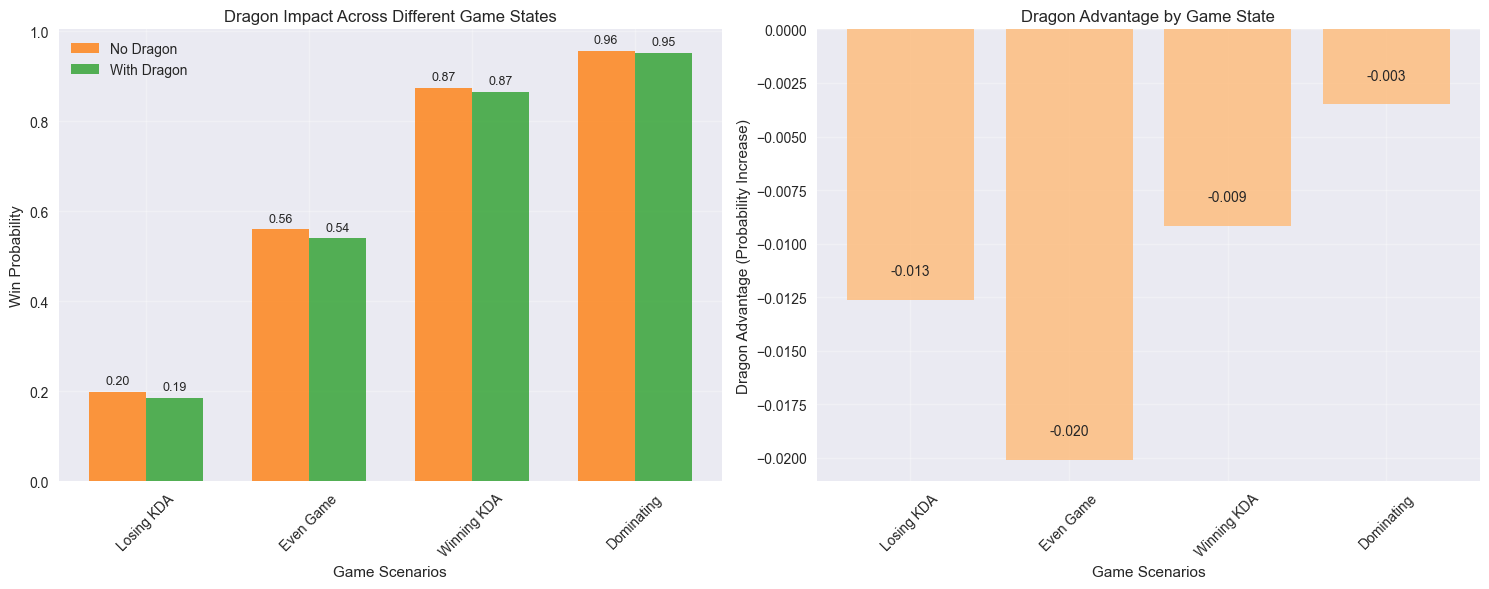

Dragon Impact Analysis:
Losing KDA  : Dragon adds -0.013 (-1.3%) win probability
Even Game   : Dragon adds -0.020 (-2.0%) win probability
Winning KDA : Dragon adds -0.009 (-0.9%) win probability
Dominating  : Dragon adds -0.003 (-0.3%) win probability


In [19]:
# 3. Dragon Impact Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Test different scenarios with and without dragon
scenarios = [
    {'name': 'Losing KDA', 'team_kda': 1.5, 'enemy_kda': 3.0, 'gold_diff': -3000},
    {'name': 'Even Game', 'team_kda': 2.0, 'enemy_kda': 2.0, 'gold_diff': 0},
    {'name': 'Winning KDA', 'team_kda': 3.0, 'enemy_kda': 1.5, 'gold_diff': 3000},
    {'name': 'Dominating', 'team_kda': 4.0, 'enemy_kda': 1.0, 'gold_diff': 5000}
]

no_dragon_probs = []
with_dragon_probs = []
scenario_names = []

for scenario in scenarios:
    scenario_names.append(scenario['name'])
    
    # Without dragon
    input_data = pd.DataFrame({
        'dragon': [0],
        'gold_diff': [scenario['gold_diff']],
        'gold_per_kill': [3000],
        'team_kda': [scenario['team_kda']],
        'enemy_kda': [scenario['enemy_kda']]
    })
    no_dragon_probs.append(model.predict_proba(input_data)[0][1])
    
    # With dragon
    input_data = pd.DataFrame({
        'dragon': [1],
        'gold_diff': [scenario['gold_diff']],
        'gold_per_kill': [3000],
        'team_kda': [scenario['team_kda']],
        'enemy_kda': [scenario['enemy_kda']]
    })
    with_dragon_probs.append(model.predict_proba(input_data)[0][1])

x = np.arange(len(scenario_names))
width = 0.35

bars1 = ax1.bar(x - width/2, no_dragon_probs, width, label='No Dragon', alpha=0.8, color='#ff7f0e')
bars2 = ax1.bar(x + width/2, with_dragon_probs, width, label='With Dragon', alpha=0.8, color='#2ca02c')

ax1.set_xlabel('Game Scenarios')
ax1.set_ylabel('Win Probability')
ax1.set_title('Dragon Impact Across Different Game States')
ax1.set_xticks(x)
ax1.set_xticklabels(scenario_names, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2f}', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# Dragon advantage calculation
dragon_advantages = [with_dragon_probs[i] - no_dragon_probs[i] for i in range(len(scenarios))]
bars3 = ax2.bar(scenario_names, dragon_advantages, color='#ffbb78', alpha=0.8)
ax2.set_xlabel('Game Scenarios')
ax2.set_ylabel('Dragon Advantage (Probability Increase)')
ax2.set_title('Dragon Advantage by Game State')
ax2.set_xticklabels(scenario_names, rotation=45)
ax2.grid(True, alpha=0.3)

# Add value labels
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("Dragon Impact Analysis:")
for i, scenario in enumerate(scenarios):
    advantage = dragon_advantages[i]
    print(f"{scenario['name']:12s}: Dragon adds {advantage:+.3f} ({advantage*100:+.1f}%) win probability")

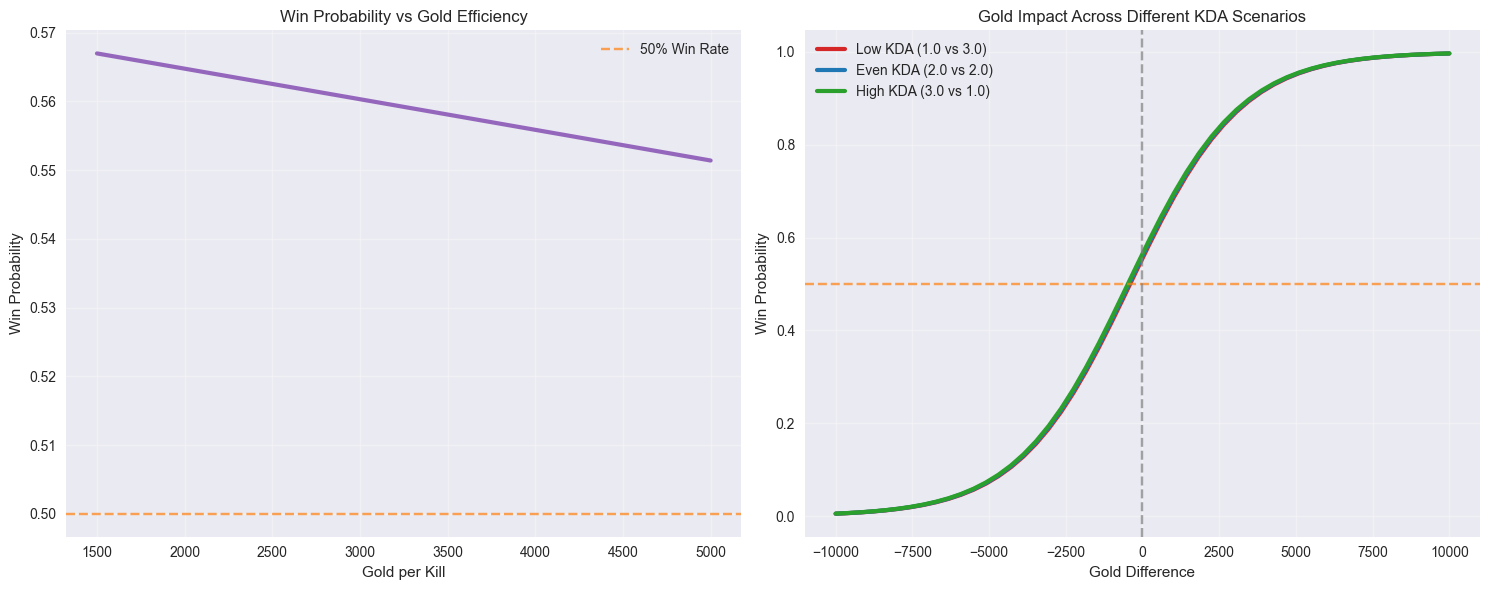

In [20]:
# 4. Gold Efficiency Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gold per kill impact
gold_per_kill_range = np.linspace(1500, 5000, 50)
gold_efficiency_probs = []

for gpk in gold_per_kill_range:
    input_data = pd.DataFrame({
        'dragon': [0],
        'gold_diff': [0],
        'gold_per_kill': [gpk],
        'team_kda': [2.0],
        'enemy_kda': [2.0]
    })
    gold_efficiency_probs.append(model.predict_proba(input_data)[0][1])

ax1.plot(gold_per_kill_range, gold_efficiency_probs, linewidth=3, color='#9467bd')
ax1.set_title('Win Probability vs Gold Efficiency')
ax1.set_xlabel('Gold per Kill')
ax1.set_ylabel('Win Probability')
ax1.axhline(y=0.5, color='#ff7f0e', linestyle='--', alpha=0.7, label='50% Win Rate')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Feature interaction: Gold difference vs different KDA scenarios
gold_range = np.linspace(-10000, 10000, 50)
kda_scenarios = [
    {'label': 'Low KDA (1.0 vs 3.0)', 'team_kda': 1.0, 'enemy_kda': 3.0, 'color': '#d62728'},
    {'label': 'Even KDA (2.0 vs 2.0)', 'team_kda': 2.0, 'enemy_kda': 2.0, 'color': '#1f77b4'},
    {'label': 'High KDA (3.0 vs 1.0)', 'team_kda': 3.0, 'enemy_kda': 1.0, 'color': '#2ca02c'}
]

for scenario in kda_scenarios:
    probs = []
    for gold_diff in gold_range:
        input_data = pd.DataFrame({
            'dragon': [0],
            'gold_diff': [gold_diff],
            'gold_per_kill': [3000],
            'team_kda': [scenario['team_kda']],
            'enemy_kda': [scenario['enemy_kda']]
        })
        probs.append(model.predict_proba(input_data)[0][1])
    
    ax2.plot(gold_range, probs, linewidth=3, color=scenario['color'], label=scenario['label'])

ax2.set_title('Gold Impact Across Different KDA Scenarios')
ax2.set_xlabel('Gold Difference')
ax2.set_ylabel('Win Probability')
ax2.axhline(y=0.5, color='#ff7f0e', linestyle='--', alpha=0.7)
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()